In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack

In [80]:
exp_id = 6

# model_name = 'train_mnist_exp%d.h5' % exp_id
# net = BasicModel()

model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

In [81]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
net.eval()

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [94]:
net.it

Parameter containing:
tensor([-4.3373, -4.3356, -4.3052], device='cuda:0', requires_grad=True)

In [82]:
net

SNNLModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [16]:
y_pred = net(x_test.to(device))

In [17]:
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.9903

In [9]:
# x_train = x_train.to(device)
# x_test = x_test.to(device)
# x_valid = x_valid.to(device)

In [115]:
net

VAE2(
  (en_conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (en_conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (en_conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (en_fc1): Linear(in_features=2048, out_features=400, bias=True)
  (relu4): ReLU(inplace)
  (en_mu): Linear(in_features=400, out_features=1000, bias=True)
  (en_logvar): Linear(in_features=400, out_features=1000, bias=True)
  (de_fc1): Linear(in_features=1000, out_features=400, bias=True)
  (de_relu1): ReLU(inplace)
  (de_fc2): Linear(in_features=400, out_features=784, bias=True)
)

In [95]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu1', 'relu2', 'relu3']
layers = ['relu1']
# layers = ['en_conv3']
# layers = ['en_mu']
# net = net.cpu()
with torch.no_grad():
    dknn = DKNN(net, x_train.cuda(), y_train, x_valid.cuda(), y_valid, layers, 
                k=10, num_classes=10)
    y_pred = dknn.classify(x_test)

In [96]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.9794

In [97]:
cred = dknn.credibility(y_pred)

(array([1025.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8975.]),
 array([0.01383333, 0.11245   , 0.21106667, 0.30968333, 0.4083    ,
        0.50691667, 0.60553333, 0.70415   , 0.80276667, 0.90138333,
        1.        ]),
 <a list of 10 Patch objects>)

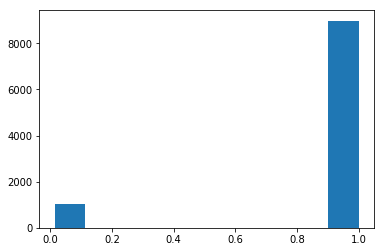

In [98]:
plt.hist(cred)

In [99]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

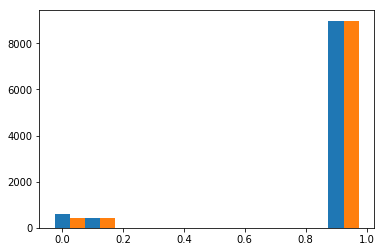

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [101]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.73195876, 0.94356659,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.99721448])

In [25]:
dknn.A.mean()

14.084

In [154]:
nn = dknn.get_neighbors(x_valid)

In [15]:
for (D, I) in nn:
    print(D[-1].mean())

0.72602546
0.6874378
0.7105881
0.94844836


## PGD Attack

In [12]:
x_test_np = x_test.cpu().numpy()
y_test_np = y_test.numpy()

In [13]:
model = foolbox.models.PyTorchModel(net, bounds=(0, 1), num_classes=10)

In [6]:
criterion = foolbox.criteria.Misclassification()
distance = foolbox.distances.Linfinity

attack = foolbox.attacks.RandomPGD(
    model, criterion=criterion, distance=distance)

def attack_wrap(x, y):
    return attack(x, y, binary_search=False, epsilon=0.3, 
                  stepsize=0.01, iterations=40, 
                  random_start=True, return_early=True)

x_adv = np.zeros_like(x_test)
for i, (x, y) in enumerate(zip(x_test, y_test)):
    x_adv[i] = attack_wrap(x, y)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


In [ ]:
with torch.no_grad():
    x_adv = torch.tensor(x_adv).to(device)
    y_pred = net(x_adv).detach().cpu().numpy()
np.mean(np.argmax(y_pred, 1) == y_test)

In [ ]:
from lib.pgd_attack import PGDAttack

attack = PGDAttack()
x_adv = attack(net, x_test, y_test.to(device),
               targeted=False, epsilon=0.1, max_epsilon=0.3,
               max_iterations=20, random_restart=10)

In [23]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test).sum()

tensor(0)

In [54]:
y_pred = dknn.classify(x_adv.cpu())
(y_pred.argmax(1) == y_test.numpy()).sum()

813

(array([9.63e+03, 2.96e+02, 5.70e+01, 7.00e+00, 5.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 4.00e+00]),
 array([0.00383333, 0.10345   , 0.20306667, 0.30268333, 0.4023    ,
        0.50191667, 0.60153333, 0.70115   , 0.80076667, 0.90038333,
        1.        ]),
 <a list of 10 Patch objects>)

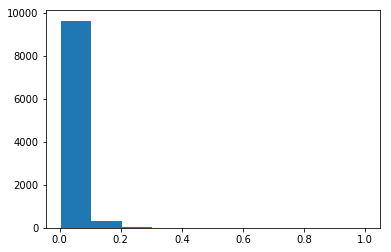

In [55]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [11]:
np.mean(y_pred == y_test)

0.9091

## DkNN Attack

In [ ]:
attack = DKNNAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y_test[begin:end],
            guide_layer='relu1', m=100, binary_search_steps=5,
            max_iterations=500, learning_rate=1e-1,
            initial_const=1e2, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000], 100)

    step: 0; loss: -540.188; l2dist: 0.000
    step: 50; loss: -541.462; l2dist: 1.008
    step: 100; loss: -542.733; l2dist: 1.315
    step: 150; loss: -543.498; l2dist: 1.439
    step: 200; loss: -543.609; l2dist: 1.454
    step: 250; loss: -543.640; l2dist: 1.458
    step: 300; loss: -543.653; l2dist: 1.459
    step: 350; loss: -543.659; l2dist: 1.460
    step: 400; loss: -543.662; l2dist: 1.461
    step: 450; loss: -543.663; l2dist: 1.461
tensor(19., device='cuda:0')
binary step: 0; number of successful adv: 19/100
    step: 0; loss: -4424.333; l2dist: 0.000
    step: 50; loss: -4465.767; l2dist: 3.392
    step: 100; loss: -4493.281; l2dist: 3.419


In [ ]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

In [ ]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [ ]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.show()

In [ ]:
y_clean = dknn.classify(x_test[:1000])
ind = (y_clean.argmax(1) == y_test[:1000].numpy()) & (y_pred.argmax(1) != y_test[:1000].numpy())
np.mean(np.sqrt(np.sum((x_adv.cpu().detach().numpy()[ind] - x_test.numpy()[:1000][ind])**2, (1, 2, 3))))

## CW L2 Attack

without DkNN

In [ ]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=5, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000].cuda(), 100)

In [273]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test[:1000]).numpy().sum() / y_pred.size(0)

AttributeError: 'tuple' object has no attribute 'argmax'

In [274]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

0.702

(array([139.,  46.,  23.,  19.,   3.,   3.,   4.,   2.,   2.,   3.]),
 array([0.0165    , 0.08763333, 0.15876667, 0.2299    , 0.30103333,
        0.37216667, 0.4433    , 0.51443333, 0.58556667, 0.6567    ,
        0.72783333]),
 <a list of 10 Patch objects>)

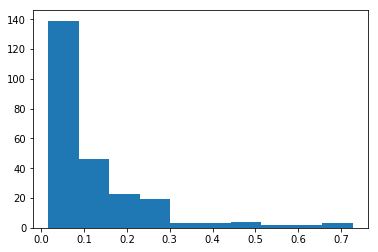

In [90]:
cred = dknn.credibility(y_pred)
suc_ind = y_pred.argmax(1) != y_test[:1000].numpy()
plt.hist(cred[suc_ind])

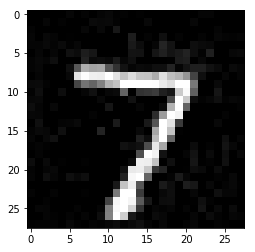

In [87]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [88]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(0.7349, grad_fn=<MeanBackward1>)

---

In [27]:
# Set all random seeds
exp_id = 0
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'train_mnist_cav_exp%d.h5' % exp_id
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
net.eval()

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [32]:
x_train = x_train.to(device)
x_test = x_test.to(device)
x_valid = x_valid.to(device)

In [28]:
net

ClassAuxVAE(
  (en_conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (en_conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (en_conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (en_fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU(inplace)
  (en_mu): Linear(in_features=128, out_features=20, bias=True)
  (en_logvar): Linear(in_features=128, out_features=20, bias=True)
  (de_fc1): Linear(in_features=20, out_features=128, bias=True)
  (de_fc2): Linear(in_features=128, out_features=1568, bias=True)
  (ax_fc1): Linear(in_features=20, out_features=128, bias=True)
  (ax_fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [59]:
layers = ['en_mu']
net = net.to(device)
with torch.no_grad():
    dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
                k=10, num_classes=10)
    y_pred = dknn.classify(x_test)

In [60]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.964

(array([ 741., 1243.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8016.]),
 array([0.01683333, 0.11515   , 0.21346667, 0.31178333, 0.4101    ,
        0.50841667, 0.60673333, 0.70505   , 0.80336667, 0.90168333,
        1.        ]),
 <a list of 10 Patch objects>)

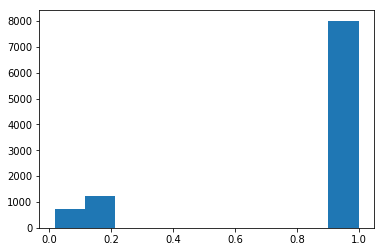

In [61]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [62]:
from lib.dknn_attack import DKNNAttack

attack = DKNNAttack()
x_adv = attack(dknn, x_test[:1000], y_test[:1000],
               guide_layer='en_mu', binary_search_steps=5,
               max_iterations=500, learning_rate=1e-1,
               initial_const=1, abort_early=True)

    step: 0; loss: -10.374; l2dist: 0.000
    step: 50; loss: -16.516; l2dist: 2.206
    step: 100; loss: -17.532; l2dist: 2.233
    step: 150; loss: -21.379; l2dist: 2.383
    step: 200; loss: -23.950; l2dist: 2.461
    step: 250; loss: -25.525; l2dist: 2.522
    step: 300; loss: -26.562; l2dist: 2.575
    step: 350; loss: -27.237; l2dist: 2.610
    step: 400; loss: -27.690; l2dist: 2.641
    step: 450; loss: -27.980; l2dist: 2.662
binary step: 0; number of successful adv: 732/1000
    step: 0; loss: -31.082; l2dist: 0.000
    step: 50; loss: -80.035; l2dist: 2.555
    step: 100; loss: -102.080; l2dist: 2.891
    step: 150; loss: -113.852; l2dist: 3.048
    step: 200; loss: -119.545; l2dist: 3.074
    step: 250; loss: -122.952; l2dist: 3.069
    step: 300; loss: -125.118; l2dist: 3.057
    step: 350; loss: -126.465; l2dist: 3.052
    step: 400; loss: -127.398; l2dist: 3.048
    step: 450; loss: -127.963; l2dist: 3.048
binary step: 1; number of successful adv: 1000/1000
    step: 0; lo

In [18]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum()

0

In [40]:
x.size()

torch.Size([1000, 128, 4, 4])

In [41]:
F.normalize(x.view(1000, -1), 2, 1).norm(2, 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

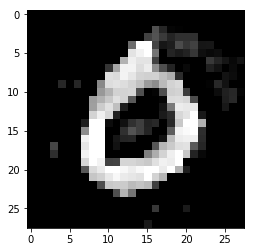

In [56]:
plt.imshow(x_adv[3].cpu().detach().numpy().squeeze(), cmap='gray')

In [20]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(1.9813, grad_fn=<MeanBackward1>)